Epoch 1: 100%|██████████| 1149/1149 [06:43<00:00,  2.85it/s]


Epoch 1: Train loss=1.6908, Val acc=0.3322


Epoch 2: 100%|██████████| 1149/1149 [06:43<00:00,  2.84it/s]


Epoch 2: Train loss=1.5232, Val acc=0.3583


Epoch 3: 100%|██████████| 1149/1149 [06:44<00:00,  2.84it/s]


Epoch 3: Train loss=1.3310, Val acc=0.3435


Epoch 4: 100%|██████████| 1149/1149 [06:43<00:00,  2.85it/s]


Epoch 4: Train loss=1.0575, Val acc=0.3217
Early stopping.


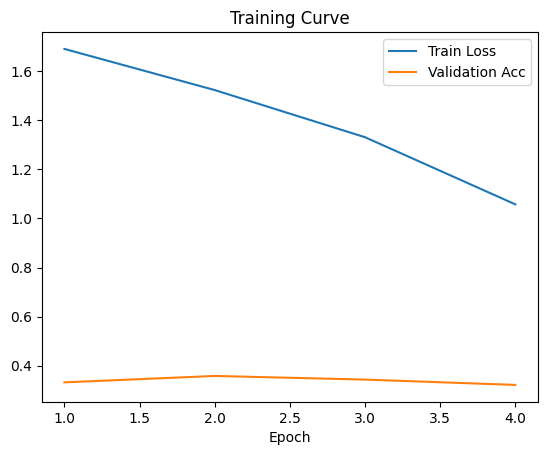

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.40      0.41       303
           1       0.50      0.40      0.45       660
           2       0.24      0.32      0.27       360
           3       0.26      0.20      0.23       371
           4       0.26      0.35      0.30       343
           5       0.23      0.21      0.22       259

    accuracy                           0.33      2296
   macro avg       0.32      0.31      0.31      2296
weighted avg       0.34      0.33      0.33      2296



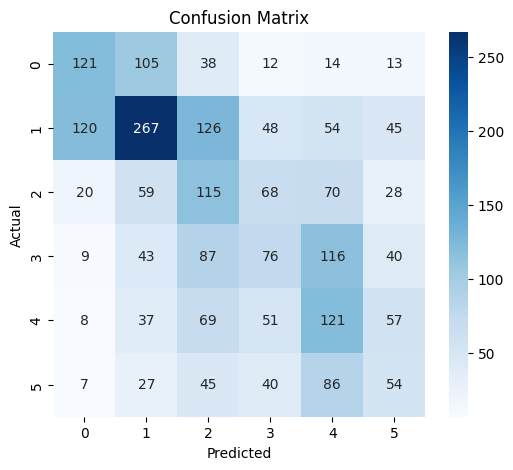


❌ Top 5 Misclassified Samples:

[3] Statement: It will cost $50,000 per enrollee in Obamacare over the next 10 years.
    ➤ True: 1 | Pred: 2

[4] Statement: The Federal Register - which houses all Washington regulations - is 34,000 pages in length and weighs in at more than 340 pounds.
    ➤ True: 3 | Pred: 5

[7] Statement: Says Wisconsin Gov. Scott Walker is making voting more difficult by closing Department of Motor Vehicles offices where "low-income voters" live.
    ➤ True: 1 | Pred: 0

[8] Statement: Says if the AHCA replaces Obamacare it will "significantly reduce insurance premiums in" North Carolina.
    ➤ True: 3 | Pred: 2

[9] Statement: Republican challenger Bill Flores "has never once voted in a general election in our district.
    ➤ True: 5 | Pred: 4


📝 Misclassified samples saved to: misclassified_samples.csv
bert_liar2_sixclass.pt


In [6]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer, get_linear_schedule_with_warmup
from torch.optim import AdamW
from torch.nn.utils import clip_grad_norm_
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import logging
from transformers.utils import logging as hf_logging

hf_logging.set_verbosity_error()
logging.getLogger("transformers").setLevel(logging.ERROR)



def load_and_prepare_multiclass_data(train_path, val_path, test_path):
    train_df = pd.read_csv(train_path)
    val_df = pd.read_csv(val_path)
    test_df = pd.read_csv(test_path)

    label_encoder = LabelEncoder()
    label_encoder.fit(train_df["label"])
    for df in [train_df, val_df, test_df]:
        df["label"] = label_encoder.transform(df["label"])

    return train_df, val_df, test_df, label_encoder.classes_

from torch.utils.data import DataLoader
import torch

def predict(model, dataset, batch_size=16):
    loader = DataLoader(dataset, batch_size=batch_size)
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    predictions = []

    with torch.no_grad():
        for batch in loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            outputs = model(**inputs)
            preds = torch.argmax(outputs, dim=1)
            predictions.extend(preds.cpu().numpy())

    return predictions

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

def analyze_predictions(preds, test_df, label_col="label", label_map=None, top_k=5, output_file="misclassified_samples.csv"):
    if label_map is None:
        label_map = {i: str(i) for i in sorted(set(test_df[label_col].tolist()))}

    true_labels = test_df[label_col].tolist()

    print("📊 Classification Report:")
    print(classification_report(true_labels, preds, target_names=[label_map[i] for i in sorted(label_map)]))

    cm = confusion_matrix(true_labels, preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[label_map[i] for i in sorted(label_map)],
                yticklabels=[label_map[i] for i in sorted(label_map)])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    test_df["true_label"] = test_df[label_col]
    test_df["predicted_label"] = preds
    test_df["correct"] = test_df["true_label"] == test_df["predicted_label"]

    mistakes = test_df[~test_df["correct"]].copy()
    mistakes["true_label_name"] = mistakes["true_label"].map(label_map)
    mistakes["predicted_label_name"] = mistakes["predicted_label"].map(label_map)

    print(f"\n❌ Top {top_k} Misclassified Samples:\n")
    for i, row in mistakes.head(top_k).iterrows():
        print(f"[{i}] Statement: {row['clean_statement_bert']}")
        print(f"    ➤ True: {row['true_label_name']} | Pred: {row['predicted_label_name']}")
        print("")

    mistakes[["clean_statement_bert", "true_label_name", "predicted_label_name"]].to_csv(output_file, index=False)
    print(f"\n📝 Misclassified samples saved to: {output_file}")

    return test_df

# ---------- Dataset ----------
class MultiClassFakeNewsDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.texts = dataframe["clean_statement_bert"].tolist()
        self.labels = dataframe["label"].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        encodings = self.tokenizer(
            self.texts[idx],
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encodings['input_ids'].squeeze(0),
            'attention_mask': encodings['attention_mask'].squeeze(0),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }# ---------- Multi-Class BERT Model ----------
class MultiClassBERTClassifier(nn.Module):
    def __init__(self, model_name, num_labels=6, dropout=0.3):
        super().__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.pooler_output
        return self.classifier(self.dropout(cls_output))
# ---------- Training Function for Multi-Class ----------
def train_multiclass_model(train_dataset, val_dataset, model, epochs=6, batch_size=16, lr=2e-5, warmup_ratio=0.1, patience=2):
    optimizer = AdamW(model.parameters(), lr=lr)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    loss_fn = nn.CrossEntropyLoss()
    total_steps = len(train_loader) * epochs
    warmup_steps = int(warmup_ratio * total_steps)

    scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, total_steps)

    train_losses, val_accuracies = [], []
    best_val_acc = 0
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for batch in val_loader:
                inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
                labels = batch['labels'].to(device)
                outputs = model(**inputs)
                preds = torch.argmax(outputs, dim=1)
                correct += (preds == labels).sum().item()
                total += len(labels)
        acc = correct / total
        val_accuracies.append(acc)

        print(f"Epoch {epoch+1}: Train loss={avg_loss:.4f}, Val acc={acc:.4f}")

        if acc > best_val_acc:
            best_val_acc = acc
            patience_counter = 0
            torch.save(model.state_dict(), "best_multiclass_model.pt")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping.")
                break

    plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
    plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label="Validation Acc")
    plt.xlabel("Epoch")
    plt.legend()
    plt.title("Training Curve")
    plt.show()

    return model

from transformers import BertTokenizer

train_df, val_df, test_df, class_names = load_and_prepare_multiclass_data(
    "/content/processed_train (2).csv",
    "/content/processed_valid (2).csv",
    "/content/processed_test (2).csv"
)

# Tokenizer & Dataset
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_set = MultiClassFakeNewsDataset(train_df, tokenizer, max_len=128)
val_set = MultiClassFakeNewsDataset(val_df, tokenizer, max_len=128)

model = MultiClassBERTClassifier("bert-base-uncased", num_labels=6)

model = train_multiclass_model(train_set, val_set, model, epochs=10, batch_size=16)

test_set = MultiClassFakeNewsDataset(test_df, tokenizer, max_len=128)

preds = predict(model, test_set)

analyze_predictions(preds, test_df)

import os
save_dir = "./saved_models"
os.makedirs(save_dir, exist_ok=True)

torch.save(model.state_dict(), os.path.join(save_dir, "bert_liar2_sixclass.pt"))
print("bert_liar2_sixclass.pt")
